In [1]:
import os
import torch.nn as nn
import numpy as np
from dloader import genDataLoader 
import sigpy as sp
import sigpy.plot as pl
from fastmri.data import transforms
from collections import Counter
import torch
from icecream import ic
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
datasets = [
    'div_coronal_pd_fs',
    'div_coronal_pd'
]

datadir = '/mnt/dense/vliu/summer_dset/'

In [3]:
basedirs = [
    os.path.join(datadir, dataset)
    for dataset in datasets
]
ic(basedirs)

ic| basedirs: ['/mnt/dense/vliu/summer_dset/div_coronal_pd_fs',
               '/mnt/dense/vliu/summer_dset/div_coronal_pd']


['/mnt/dense/vliu/summer_dset/div_coronal_pd_fs',
 '/mnt/dense/vliu/summer_dset/div_coronal_pd']

In [4]:
train_dloader = genDataLoader(
    [f'{basedir}/Test' for basedir in basedirs],
    [0, 0], # downsample
    center_fractions = [0.06],
    accelerations = [6],
    num_workers= 16,
    shuffle = True,
    stratified = 1, method = 'upsample'
)

In [49]:
dloader = iter(train_dloader[0])
ic(len(dloader)) # length of the dataset

ic| len(dloader): 290


290

In [38]:
for kspace, mask, esp, im_fs, contrast in dloader:
#    im_fs = transforms.tensor_to_complex_np(im_fs)
    ic(im_fs.shape)
    if contrast[0] == 'div_coronal_pd_fs': # This is contrast 0
        input_contrast = 0
    else:
        input_contrast = 1
    ic(input_contrast)

ic| im_fs.shape: torch.Size([1, 1, 360, 320, 2])
ic| input_contrast: 0


KeyboardInterrupt: 

# Now reviewing MTL model

In [ ]:
from models import MTL_VarNet

In [17]:
from collections import Counter
import numpy as np

import torch
import torch.nn as nn

from typing import List

import fastmri
from fastmri.models.varnet import NormUnet
from utils import Tensor_Hook

In [29]:
class VarNetBlockShared(nn.Module):
    """
    Hard-coded for only two contrasts
    """
    def __init__(self, model: nn.Module):
        super().__init__()

        self.model = model
        self.eta1 = nn.Parameter(torch.ones(1)) # for eta1
        self.eta2 = nn.Parameter(torch.ones(1)) # for eta2
        
    def sens_expand(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        return fastmri.fft2c(fastmri.complex_mul(x, sens_maps)) # F*S operator

    def sens_reduce(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        x = fastmri.ifft2c(x)
        return fastmri.complex_mul(x, fastmri.complex_conj(sens_maps)).sum(
            dim=1, keepdim=True
        ) # S^H * F^H operator

    def forward(
        self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor,
        sens_maps: torch.Tensor,
        int_contrast: int
    ) -> torch.Tensor:
        '''
        note that contrast is not str, but rather int index of opt.datasets
        this is implemented in the VarNet portion
        '''

        mask = mask.bool()
        zero = torch.zeros(1, 1, 1, 1, 1).to(current_kspace)
        if int_contrast == 0:
            soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.eta1
        else:
            soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.eta2

        model_term = self.sens_expand(
            self.model(
                self.sens_reduce(current_kspace, sens_maps)), 
                sens_maps
        )

        return current_kspace - soft_dc - model_term
    
    
class VarNetBlockUnshared(nn.Module):

    def __init__(self, model1: nn.Module, model2:nn.Module):
        super().__init__()

        self.model1 = model1
        self.eta1 = nn.Parameter(torch.ones(1))
        
        self.model2 = model2
        self.eta2 = nn.Parameter(torch.ones(1))
 
    def sens_expand(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        return fastmri.fft2c(fastmri.complex_mul(x, sens_maps)) # F*S operator

    def sens_reduce(self, x: torch.Tensor, sens_maps: torch.Tensor) -> torch.Tensor:
        x = fastmri.ifft2c(x)
        return fastmri.complex_mul(x, fastmri.complex_conj(sens_maps)).sum(
            dim=1, keepdim=True
        ) # S^H * F^H operator

    def forward(
        self,
        current_kspace: torch.Tensor,
        ref_kspace: torch.Tensor,
        mask: torch.Tensor,
        sens_maps: torch.Tensor,
        int_contrast: int
    ) -> torch.Tensor:
        '''
        note that contrast is not str, but rather int index of opt.datasets
        this is implemented in the VarNet portion
        '''
        assert int_contrast == 0 or int_contrast == 1, 'Only two contrasts are allowed'
    
        mask = mask.bool()
        zero = torch.zeros(1, 1, 1, 1, 1).to(current_kspace)
        
        if int_contrast == 0:
            soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.eta1
            model_term = self.sens_expand(
            self.model1(
                self.sens_reduce(current_kspace, sens_maps)), 
                sens_maps
            )
            
            return current_kspace - soft_dc - model_term
        else:
            soft_dc = torch.where(mask, current_kspace - ref_kspace, zero) * self.eta2
            model_term = self.sens_expand(
            self.model2(
                self.sens_reduce(current_kspace, sens_maps)), 
                sens_maps
            )
            
            return current_kspace - soft_dc - model_term

class VarNet(nn.Module):
    """
    A full variational network model.

    This model applies a combination of soft data consistency with a U-Net
    regularizer. To use non-U-Net regularizers, use VarNetBock.
    """
    def __init__(
        self,
        num_shared: int = 3,  # unshared shared unshared shared unshared shared (this is 6 unrolls)
        num_final_unshared: int = 4,  # multi head blocks
        chans: int = 12,
        pools: int = 4,
    ):
        super().__init__()

        self.shared_cascades = nn.ModuleList()
        self.unshared_cascades = nn.ModuleList()

        for it in range(num_shared):
            module_name = 'Shared' + str(it)
            self.shared_cascades.add_module(
                module_name, VarNetBlockShared(NormUnet(chans, pools)))
            module_name = 'UnShared' + str(it)
            self.shared_cascades.add_module(
                module_name,
                VarNetBlockUnshared(NormUnet(chans, pools),
                                    NormUnet(chans, pools)))

        for it in range(num_final_unshared): # This is final multiple heads
            module_name = 'FinalUnShared' + str(it)
            self.unshared_cascades.add_module(
                module_name,
                VarNetBlockUnshared(NormUnet(chans, pools),
                                    NormUnet(chans, pools)))

    def forward(self, masked_kspace: torch.Tensor, mask: torch.Tensor,
                esp_maps: torch.Tensor, int_contrast:int) -> torch.Tensor:
        kspace_pred = masked_kspace.clone()

        for cascade in self.shared_cascades:
            kspace_pred = cascade(kspace_pred, masked_kspace, mask, esp_maps, int_contrast)
        for cascade in self.unshared_cascades:
            kspace_pred = cascade(kspace_pred, masked_kspace, mask, esp_maps, int_contrast)
        
        im_coil = fastmri.ifft2c(kspace_pred)
        im_comb = fastmri.complex_mul(im_coil, fastmri.complex_conj(esp_maps)).sum(
            dim=1, keepdim=True
        )
        
        return im_comb

# Train for one whole test-set and infer on the same test-set

In [55]:
varnet = VarNet(1,1,12,2) # very simple varnet for reviewing

In [56]:
criterion = nn.L1Loss() # simple loss func

In [57]:
optimizer = torch.optim.Adam(varnet.parameters(),lr=0.0002)

In [58]:
dloader = iter(train_dloader[0]) # dloader

In [59]:
loss_two_contrast_average = 0 # for viewing losses

for kspace, mask, esp, im_fs, contrast in dloader:
#    im_fs = transforms.tensor_to_complex_np(im_fs)
    if contrast[0] == 'div_coronal_pd_fs': # This is contrast 0
        input_contrast = 0
    else:
        input_contrast = 1
    
    pred = varnet(kspace, mask, esp, input_contrast)
    pred = transforms.complex_center_crop(pred, tuple(im_fs.shape[2:4]))
    
    loss = criterion(pred, im_fs)
    loss.backward()
    loss_two_contrast_average += loss.item()
    
    if input_contrast == 1:
        optimizer.step()
        optimizer.zero_grad()
        print(loss_two_contrast_average)
        loss_two_contrast_average = 0 # seems like decreasing ... 

0.265869677066803
0.23141495138406754
0.21222736209165305
0.15278787165880203
0.2333047166466713
0.22245310246944427
0.2800138294696808
0.17547240108251572
0.15645385161042213
0.23897507041692734
0.13786309212446213
0.17860852926969528
0.08725730888545513
0.12660696357488632
0.22317402809858322
0.19916551560163498
0.22564466297626495
0.1859583519399166
0.21398456767201424
0.08394000306725502
0.21618325263261795
0.17396342754364014
0.203403078019619
0.1673821434378624
0.21481703221797943
0.07223077490925789
0.15370604023337364
0.11768262088298798
0.2081301137804985
0.09263064339756966
0.1660132333636284
0.08108342625200748
0.15387206617742777
0.08977124840021133
0.16212129592895508
0.09885971806943417
0.1918133646249771
0.04083317704498768
0.14179906249046326
0.1066454853862524
0.046362197026610374
0.13132677972316742
0.15590664371848106
0.12587541714310646
0.12038832157850266
0.18166113644838333
0.11926844716072083
0.11516796424984932
0.1604543924331665
0.16716931015253067
0.1914295032

In [60]:
testloader = iter(train_dloader[0]) # dloader

In [97]:
kspace1, mask1, esp1, im_fs1, contrast1 = next(testloader)
if contrast1[0] == 'div_coronal_pd_fs': # This is contrast 0
    input_contrast = 0
else:
    input_contrast = 1
ic(input_contrast) # This is coronal_pd_fs (contrast #0)

ic| input_contrast: 0


0

In [98]:
with torch.no_grad():
    pred1 = varnet(kspace1, mask1, esp1, input_contrast)
    pred1 = transforms.complex_center_crop(pred1, tuple(im_fs.shape[2:4]))
    
    ic(pred1.shape)

ic| pred1.shape: torch.Size([1, 1, 360, 320, 2])


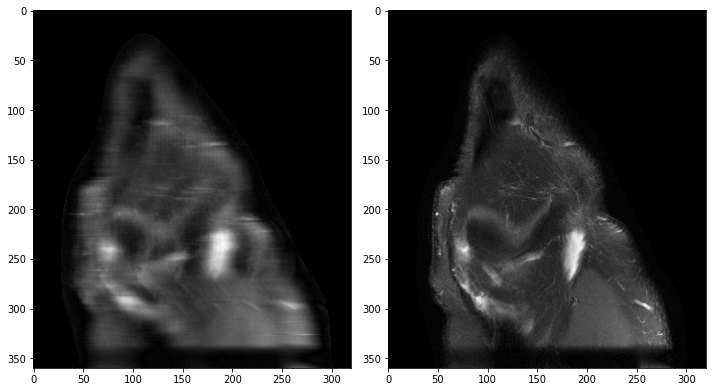

In [99]:
# now look at the image
pred1_numpy = transforms.tensor_to_complex_np(pred1)
im_fs1_numpy = transforms.tensor_to_complex_np(im_fs1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(np.abs(pred1_numpy.squeeze()), cmap='gray')
ax2.imshow(np.abs(im_fs1_numpy.squeeze()), cmap='gray')

fig.tight_layout()

In [93]:
kspace2, mask2, esp2, im_fs2, contrast2 = next(testloader)
if contrast2[0] == 'div_coronal_pd_fs': # This is contrast 0
    input_contrast = 0
else:
    input_contrast = 1
ic(input_contrast) # This is coronal_pd_fs (contrast #0)

ic| input_contrast: 1


1

In [95]:
with torch.no_grad():
    pred2 = varnet(kspace2, mask2, esp2, input_contrast)
    pred2 = transforms.complex_center_crop(pred2, tuple(im_fs2.shape[2:4]))
    
    ic(pred2.shape)

ic| pred2.shape: torch.Size([1, 1, 360, 320, 2])


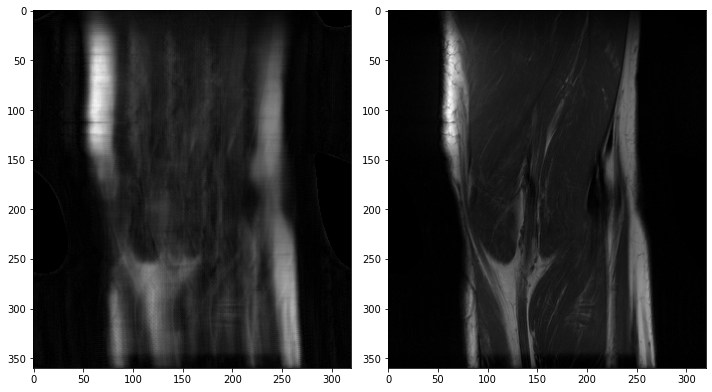

In [96]:
# now look at the image
pred2_numpy = transforms.tensor_to_complex_np(pred2)
im_fs2_numpy = transforms.tensor_to_complex_np(im_fs2)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(np.abs(pred2_numpy.squeeze()), cmap='gray')
ax2.imshow(np.abs(im_fs2_numpy.squeeze()), cmap='gray')

fig.tight_layout()